In [1]:
'''
This notebook uses qiskit adhoc data set to study quantum inspired classification.

Data Source: Qiskit builtin adhoc dataset
'''
'''
# Some epxerimental results from running this notebook on IBM Quantum Lab 
# random_state=0
# comparison study without dimension reduction

# train/test=300/200
# normilize=no
# feature=3
# gap        accuracy  method 
# 0.3        50%       SVC-linear
# 0.3        49%       SVC-rbf kernel   
# 0.3        100%      SVC-quantum  
# 0.3        100%      QVC-SPSA-3

# 0.0001     42%       SVC-linear
# 0.0001     53%       SVC-rbf kernel
# 0.0001     87%       SVC-quantum kernel
# 0.0001     75%       QVC-SPSA-3

# 0.000001   42%       SVC-linear
# 0.000001   53%       SVC-rbf kernel
# 0.000001   87%       SVC-quantum kernel
# 0.000001   61%       QVC-SPSA-3
'''


## define dataset difficulty
feature_dimensions=3  # Must be 2 or 3

# data set difficulty increases with smaller gap value
instance_gap=0.0001

# config
normalizeFeature=False
toViz=True
seed=0
subtrainset=300  
subtestset=100

In [2]:
import numpy as np

# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, transpile, Aer, IBMQ
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from ibm_quantum_widgets import *
from qiskit.providers.aer import * #QasmSimulator

# Loading your IBM Quantum account(s)
provider = IBMQ.load_account()

# Check backends' availability
backends = IBMQ.providers()[0].backends()
print('{:<10} {:<14} {}'.format('Available', 'pending_jobs', 'name'))
for backend in backends:
    status = backend.status()
    print('{:<10} {:<14} {}'.format('True' if status.operational==1 else 'False',
                                    status.pending_jobs, backend.name()))

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


Available  pending_jobs   name
True       0              ibmq_qasm_simulator
True       545            ibmq_lima
True       83             ibmq_belem
True       64             ibmq_quito
True       0              simulator_statevector
True       0              simulator_mps
True       0              simulator_extended_stabilizer
True       0              simulator_stabilizer
True       97             ibmq_manila
True       288            ibm_nairobi
True       111            ibm_oslo


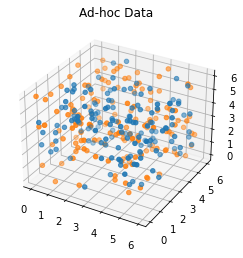

Train binary classifiers with Support Vector Machine.

Data set: Qiskit Adhoc
Input feature dimensions 3.
Normalize input feature: False

Entire data set : 300 (training) and 100 (testing)
Linear kernel - Test accuracy = 42.0%
RBF kernel - Test accuracy = 53.0%


In [3]:
import pandas as pd
import random
import time
random.seed(0)

from qiskit.utils import algorithm_globals
from qiskit_machine_learning.datasets import ad_hoc_data
from sklearn import preprocessing

algorithm_globals.random_seed = seed
np.random.seed(algorithm_globals.random_seed)

train_data, train_labels, test_data, test_labels = (
    ad_hoc_data(training_size=int(subtrainset/2),
                test_size=int(subtestset/2),
                n=feature_dimensions,
                gap=instance_gap,
                one_hot=False,
                plot_data=True
            ))

if normalizeFeature:
    min_max_scaler = preprocessing.MinMaxScaler(feature_range=(-1,1))
    train_data= pd.DataFrame(min_max_scaler.fit_transform(train_data))
    test_data= pd.DataFrame(min_max_scaler.fit_transform(test_data))
else:
    pass
    
print("Train binary classifiers with Support Vector Machine.\n")
print("Data set: Qiskit Adhoc")
print(f"Input feature dimensions {feature_dimensions}.")

## train SVCs with Linear and RBF kernels
from sklearn.svm import SVC    
    
print(f"Normalize input feature: {normalizeFeature}\n")
print(f"Entire data set : {len(train_data)} (training) and {len(test_data)} (testing)")

model = SVC(kernel='linear', random_state=seed, probability=True)
model.fit(train_data, train_labels)
accuracy_linear = model.score(test_data, test_labels)
print("Linear kernel - Test accuracy = {:<4.1f}%".format(accuracy_linear*100))

model = SVC(kernel='rbf', random_state=seed, probability=True)
model.fit(train_data, train_labels)
accuracy_rbf = model.score(test_data, test_labels)
print("RBF kernel - Test accuracy = {:<4.1f}%".format(accuracy_rbf*100))

Normalize input feature: False
feature_dimensions 3
instance_gap 0.0001 

17 seconds for computing train (300) and test (100) sets' kernels .
Quantum kernel (circuit_depth=2) - Test accuracy = 87.0%


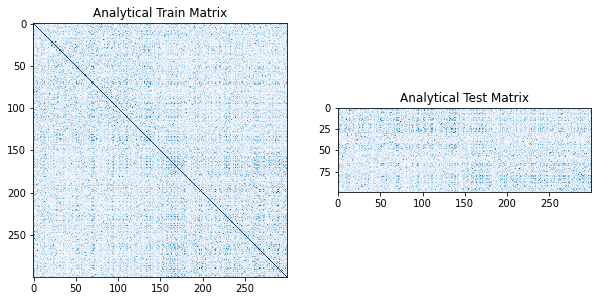

In [4]:
# Compare SVC method with with quantum kernel 
from qiskit.circuit.library import ZZFeatureMap
from qiskit import opflow

# define quantum feature map
circuit_depth=2
my_feature_map = ZZFeatureMap(feature_dimension=feature_dimensions, 
                            reps=circuit_depth)

def calculate_kernel(feature_map, x_data, y_data=None):
    if y_data is None: y_data=x_data 
    x_circuits = opflow.CircuitStateFn(feature_map).bind_parameters(
        dict(zip(feature_map.parameters, np.transpose(x_data).tolist()))
        )
    y_circuits = opflow.CircuitStateFn(feature_map).bind_parameters(
        dict(zip(feature_map.parameters, np.transpose(y_data).tolist()))
        ) 
    kernel = np.abs(
        (~y_circuits.to_matrix_op() @ x_circuits.to_matrix_op()).eval()
    )**2
    return kernel

print(f"Normalize input feature: {normalizeFeature}")
print('feature_dimensions', feature_dimensions)
print('instance_gap', instance_gap, '\n')

# compute quantum kernel
t1=time.time()
train_kernel = calculate_kernel(my_feature_map, np.array(train_data))
test_kernel = calculate_kernel(my_feature_map,  np.array(train_data), np.array(test_data))
t2=time.time()
print(f"{int(t2-t1)} seconds for computing train ({len(train_kernel)}) and test ({len(test_kernel)}) sets' kernels .")

# train SVC with quantum kernel
q_model = SVC(kernel='precomputed', random_state=seed, probability=True)
q_model.fit(train_kernel, train_labels)
q_accuracy = q_model.score(test_kernel, test_labels)
print("Quantum kernel (circuit_depth={}) - Test accuracy = {:<4.1f}%".format(\
                                                circuit_depth, q_accuracy*100))

# visualize computed kernels
if toViz:
    import matplotlib.pyplot as plt
    fig, axs = plt.subplots(1, 2, figsize=(10,5))
    axs[0].imshow(np.asmatrix(train_kernel), interpolation='nearest',
                  origin='upper', cmap='Blues')
    axs[0].set_title("Analytical Train Matrix")
    axs[1].imshow(np.asmatrix(test_kernel), 
                    interpolation='nearest',
                      origin='upper', cmap='Blues')
    axs[1].set_title("Analytical Test Matrix")
    plt.show()

/tmp/ipykernel_220/3019348612.py:41: DeprecationWarning: The quantum_instance argument is deprecated as of version 0.5.0 and will be removed no sooner than 3 months after the release. Instead use the sampler argument.
  vqc = VQC(feature_map=FEATURE_MAP,


Normalize input feature: False
feature_dimensions 3
instance_gap 0.0001 

1350 seconds for training VQC
3 qubits | Accuracy : Test 75.0%   Train 69.7%


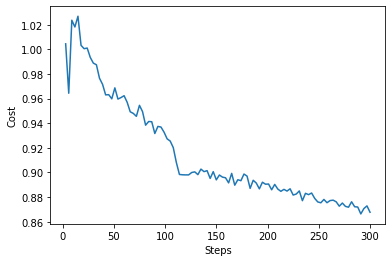

In [5]:
# Compare with QVC method
from qiskit.circuit.library import ZZFeatureMap, TwoLocal
from qiskit_machine_learning.algorithms.classifiers import VQC
from sklearn.preprocessing import OneHotEncoder
from qiskit import BasicAer
from qiskit.algorithms.optimizers import SPSA
import time

backend_name='qasm_simulator' #'ibmq_lima' 'qasm_simulator' 

# Encoding data and labels
FEATURE_MAP = ZZFeatureMap(feature_dimension=feature_dimensions, reps=2)
VAR_FORM = TwoLocal(
                feature_dimensions, 
                ['ry', 'rz'],       # parameterized single qubit rotations 
                'cz',               # entangling gate
                reps=2,             # layers
                insert_barriers=True
            )

encoder = OneHotEncoder()
train_labels_oh = encoder.fit_transform(np.array(train_labels).reshape(-1, 1)).toarray()
test_labels_oh = encoder.fit_transform(np.array(test_labels).reshape(-1, 1)).toarray()

# Setup training monitor log
class Optimizerlog:
    def __init__(self):
        self.evaluations = []
        self.parameters = []
        self.costs = []
        
    def update(self, evaluation, parameter, cost, _stepsize, _accept):
        self.evaluations.append(evaluation)
        self.parameters.append(parameter)
        self.costs.append(cost)
#        
log = Optimizerlog()    


# Construct VQC object
vqc = VQC(feature_map=FEATURE_MAP,
          ansatz=VAR_FORM,
          optimizer=SPSA(callback=log.update),
          loss='cross_entropy',
          quantum_instance=BasicAer.get_backend(backend_name),   
         )

print(f"Normalize input feature: {normalizeFeature}")
print('feature_dimensions', feature_dimensions)
print('instance_gap', instance_gap, '\n')

t1=time.time()
vqc.fit(np.array(train_data), np.array(train_labels_oh))
print(f"{int(time.time()-t1)} seconds for training VQC")

acc_train = vqc.score(train_data, train_labels_oh)
acc_test = vqc.score(test_data, test_labels_oh)
print("{} qubits | Accuracy : Test {:<4.1f}%   Train {:<4.1f}%".format(\
                    feature_dimensions, acc_test*100, acc_train*100))

# plot loss curve
fig = plt.figure()
plt.plot(log.evaluations, log.costs)
plt.xlabel('Steps')
plt.ylabel('Cost')
plt.show('Train loss curve')